# CRISP-DM: Cross-Industry Standard Process for Data Mining

CRISP-DM es un proceso estándar para la minería de datos que se utiliza para guiar a los profesionales de datos a través de la implementación de proyectos de minería de datos. Consiste en seis fases principales: comprensión del negocio, comprensión de los datos, preparación de los datos, modelado, evaluación y despliegue. En este notebook, se aplicará el proceso CRISP-DM a un problema de clasificación de quiebra empresarial utilizando un conjunto de datos financiero.

## 1. Entendimiento de negocio

### Objetivo de negocio
El objetivo de negocio es predecir la probabilidad de quiebra de una empresa utilizando datos financieros históricos. Esta predicción permitirá a las empresas y a los inversores tomar decisiones informadas sobre la gestión de riesgos y la asignación de recursos, mejorando así la estabilidad financiera y la rentabilidad.

### Objetivo analítico
El objetivo analítico es construir un modelo de machine learning que pueda clasificar si una empresa se declarará en quiebra o no, basado en las características financieras proporcionadas en el dataset. El modelo debe ser preciso y robusto, capaz de manejar datos financieros complejos y proporcionar predicciones confiables.

## 2. Entendimiento de los datos

### Análisis univariante y bivariante

Para entender mejor los datos, realizaremos un análisis univariante y bivariante utilizando Python. Esto incluirá la visualización de distribuciones de variables individuales y la relación entre pares de variables. También realizaremos algunas transformaciones de datos si es necesario.

Primero, cargaremos los datos y realizaremos un análisis univariante.

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings('ignore')

In [18]:
# Cargar los datos
data = pd.read_csv('Taller2_data.csv')

# Mostrar las primeras filas del dataset
print(data.head())

   Bankrupt?   ROA(C) before interest and depreciation before interest  \
0          1                                           0.370594          
1          1                                           0.464291          
2          1                                           0.426071          
3          1                                           0.399844          
4          1                                           0.465022          

    ROA(A) before interest and % after tax  \
0                                 0.424389   
1                                 0.538214   
2                                 0.499019   
3                                 0.451265   
4                                 0.538432   

    ROA(B) before interest and depreciation after tax  \
0                                           0.405750    
1                                           0.516730    
2                                           0.472295    
3                                           0.4577

In [19]:
# Información general del dataset
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

In [20]:
print(data.shape)

(6819, 96)


El dataset contiene 6819 registros y 96 variables, incluyendo una variable objetivo 'Bankrupt?' que indica si la empresa se declaró en quiebra o no. A continuación, realizaremos un análisis univariante y bivariante de los datos.

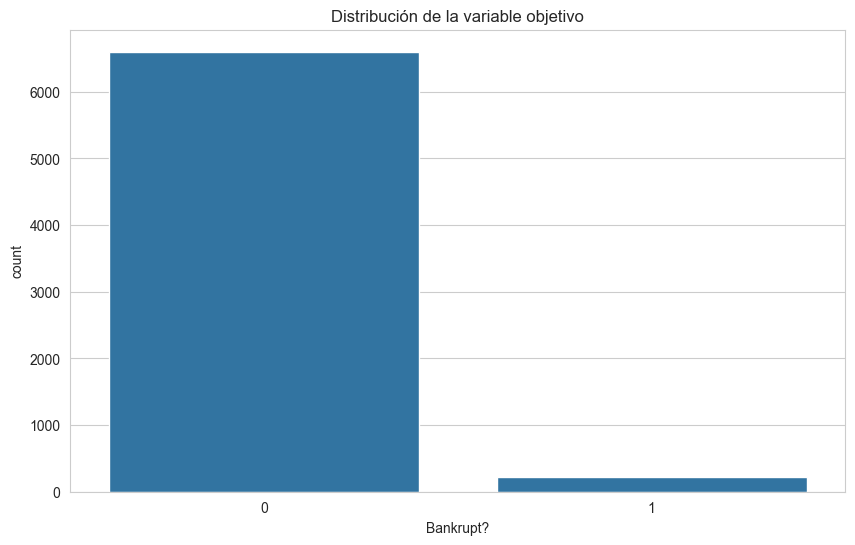

In [21]:
# Análisis univariante
# Histograma de la variable objetivo
plt.figure(figsize=(10, 6))
sns.countplot(x='Bankrupt?', data=data)
plt.title('Distribución de la variable objetivo')
plt.show()

La variable objetivo 'Bankrupt?' es binaria, con la mayoría de las empresas no declaradas en quiebra. A continuación, visualizaremos las distribuciones de las variables financieras.

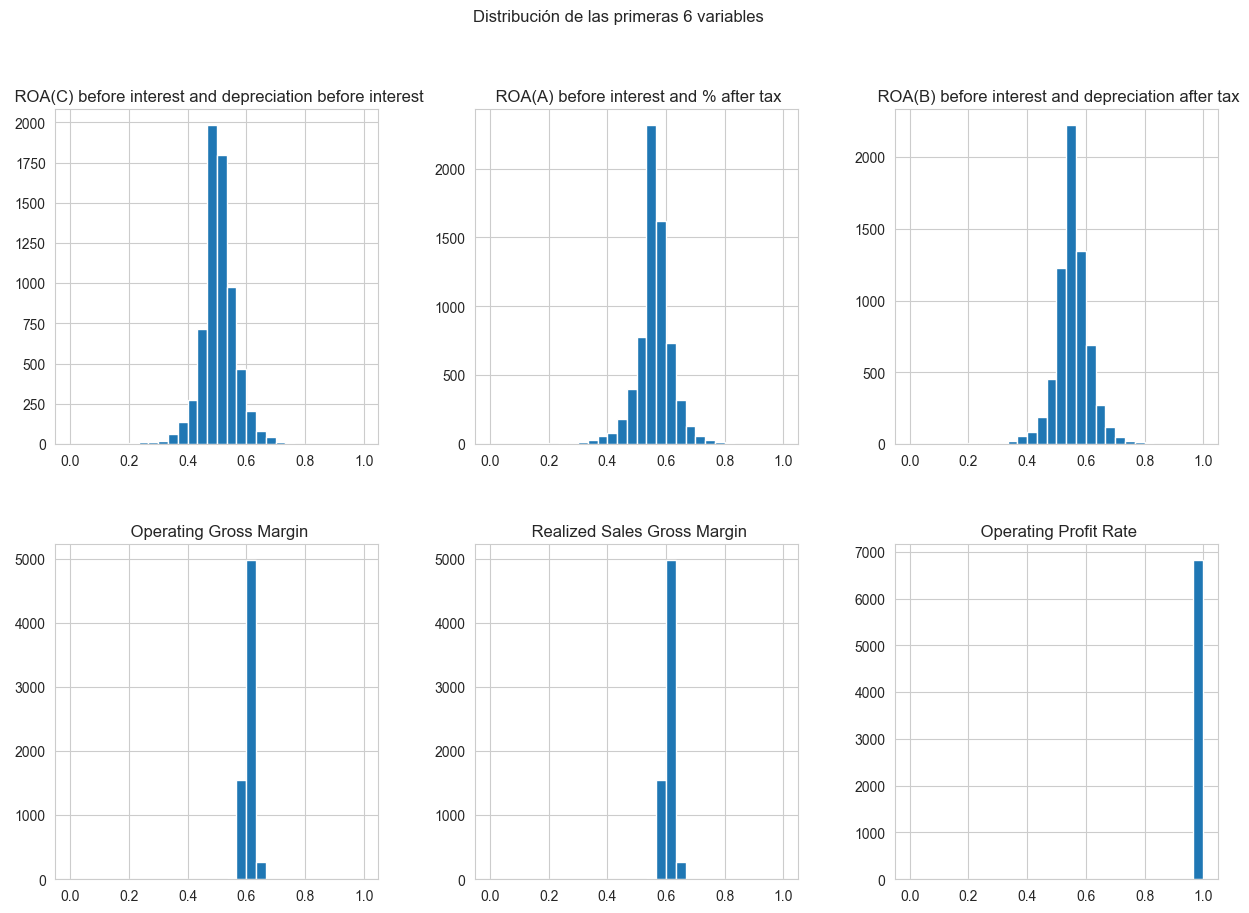

In [22]:
# Histograma de las primeras 6 variables
data.iloc[:, 1:7].hist(bins=30, figsize=(15, 10), layout=(2, 3))
plt.suptitle('Distribución de las primeras 6 variables')
plt.show()

A continuación, realizaremos un análisis bivariante para entender las relaciones entre las variables.

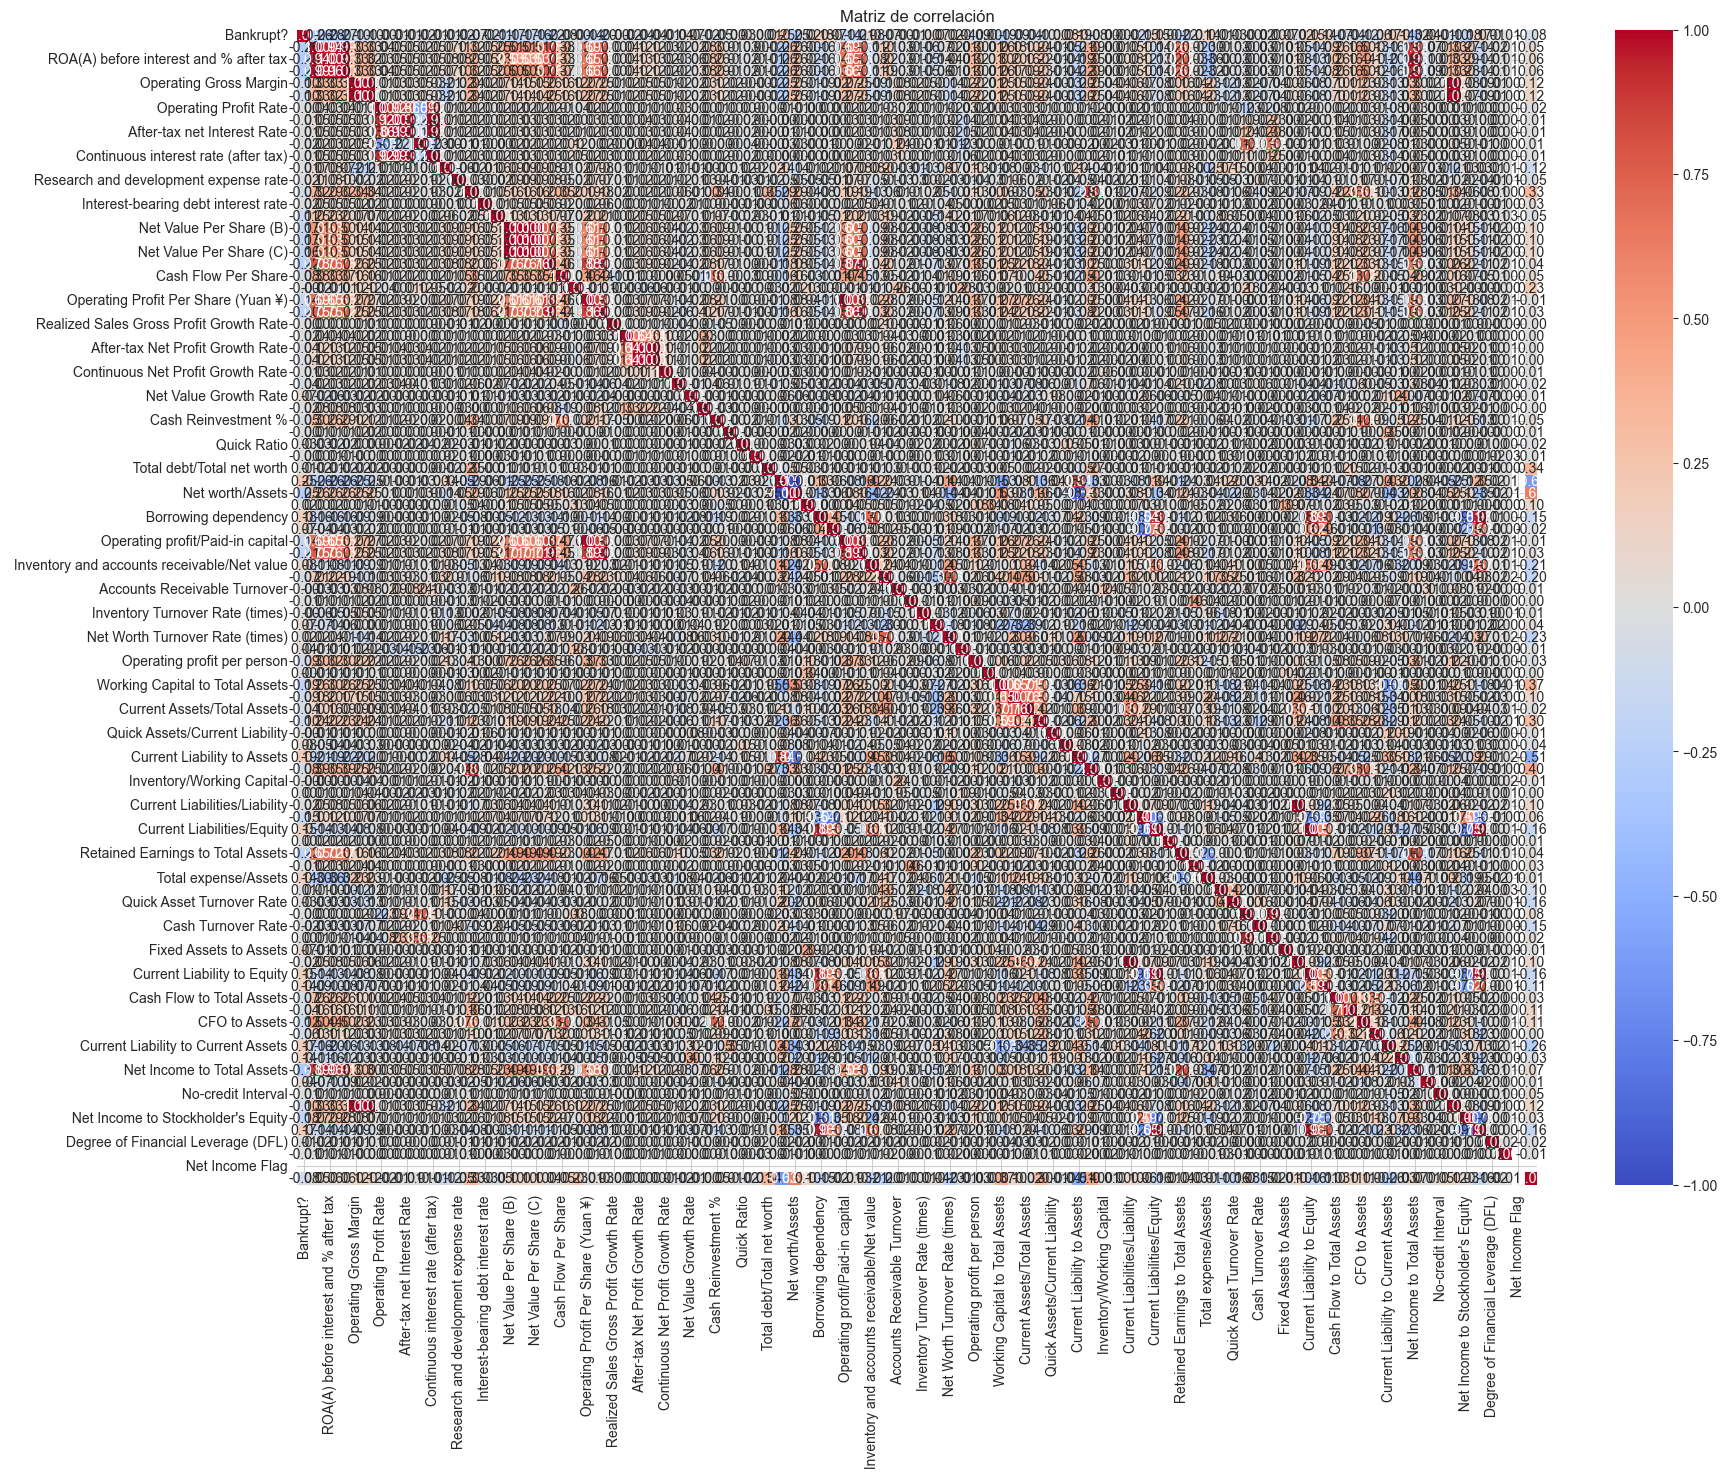

In [23]:
# Análisis bivariante
# Matriz de correlación
plt.figure(figsize=(20, 15))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Matriz de correlación')
plt.show()

La matriz de correlación nos muestra las relaciones lineales entre las variables. En este caso son muchas variables, por lo que la matriz es difícil de interpretar. A continuación, sacaremos las variables mas significativas a la variable objetivo, basandonos en el valor P y la correlación.

In [42]:
# Calcular los valores p
def calculate_p_values(data):
    p_values = pd.Series(index=data.columns)
    for column in data.columns:
        if column != 'Bankrupt?':
            try:
                model = sm.Logit(data['Bankrupt?'], sm.add_constant(data[column]))
                result = model.fit(disp=0)
                if len(result.pvalues) > 1:
                    p_values[column] = result.pvalues.iloc[1]  # Use iloc to access by position
                else:
                    p_values[column] = None  # Handle the case where pvalues does not have the expected length
            except np.linalg.LinAlgError:
                p_values[column] = None  # Skip columns that cause singular matrix error
    return p_values

In [43]:
# Función para seleccionar variables basadas en múltiples criterios
def select_significant_variables(correlation_with_target, p_values, correlation_matrix, correlation_threshold, p_value_threshold, correlation_threshold_between_predictors):
    significant_variables = correlation_with_target[correlation_with_target > correlation_threshold].index
    significant_variables = significant_variables.intersection(p_values[p_values < p_value_threshold].index)

    # Eliminar variables altamente correlacionadas entre sí
    to_remove = set()
    for i in range(len(significant_variables)):
        for j in range(i + 1, len(significant_variables)):
            if abs(correlation_matrix.loc[significant_variables[i], significant_variables[j]]) > correlation_threshold_between_predictors:
                to_remove.add(significant_variables[j])
    significant_variables = [var for var in significant_variables if var not in to_remove]

    return significant_variables

In [44]:
# Normalizar los datos, excluyendo la variable objetivo
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data.drop(columns=['Bankrupt?'])), columns=data.columns.drop('Bankrupt?'))
data_scaled['Bankrupt?'] = data['Bankrupt?']  # Añadir la variable objetivo sin normalizar

In [45]:
# Calcular la correlación de todas las variables con la variable objetivo
correlation_with_target = data_scaled.corr()['Bankrupt?'].abs().sort_values(ascending=False)

# Calcular los valores p
p_values = calculate_p_values(data_scaled)

In [48]:
correlation_with_target

Bankrupt?                                                   1.000000
 Net Income to Total Assets                                 0.315457
 ROA(A) before interest and % after tax                     0.282941
 ROA(B) before interest and depreciation after tax          0.273051
 ROA(C) before interest and depreciation before interest    0.260807
                                                              ...   
 Long-term Liability to Current Assets                      0.000778
 Cash Flow to Sales                                         0.000479
 Realized Sales Gross Profit Growth Rate                    0.000458
 Operating Profit Rate                                      0.000230
 Net Income Flag                                                 NaN
Name: Bankrupt?, Length: 96, dtype: float64

In [47]:
p_values

 ROA(C) before interest and depreciation before interest    1.862659e-67
 ROA(A) before interest and % after tax                     1.135077e-66
 ROA(B) before interest and depreciation after tax          1.429465e-66
 Operating Gross Margin                                     2.485134e-07
 Realized Sales Gross Margin                                3.293540e-07
                                                                ...     
 Degree of Financial Leverage (DFL)                         4.228706e-01
 Interest Coverage Ratio (Interest expense to EBIT)         6.458192e-01
 Net Income Flag                                                     NaN
 Equity to Liability                                        4.671758e-23
Bankrupt?                                                            NaN
Length: 96, dtype: float64

In [49]:
# Seleccionar variables basadas en múltiples criterios
correlation_threshold = 0.1
p_value_threshold = 0.05
correlation_threshold_between_predictors = 0.8
significant_variables = select_significant_variables(correlation_with_target, p_values, data.corr(), correlation_threshold, p_value_threshold, correlation_threshold_between_predictors)

In [50]:
# Seleccionar las 10 variables más significativas (excluyendo la variable objetivo)
top_variables = significant_variables[:10]

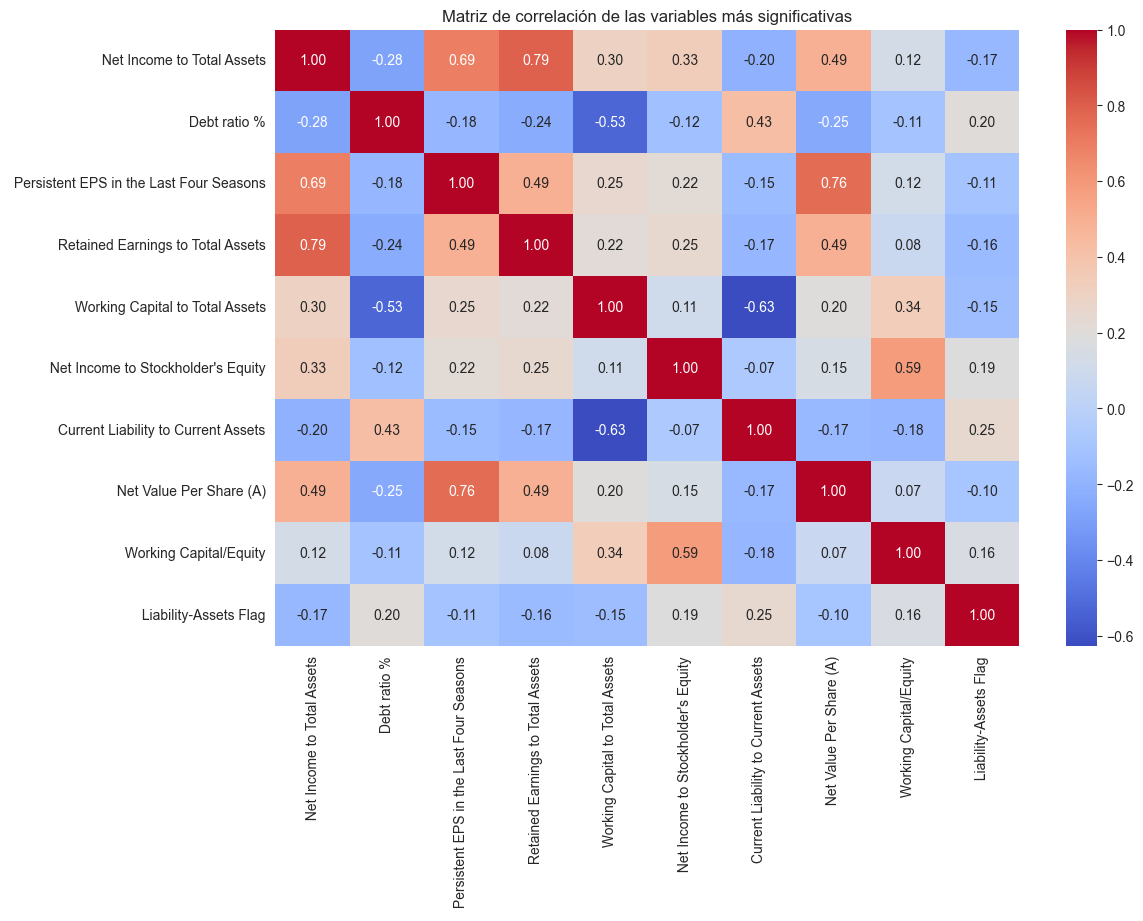

In [51]:
# Crear una matriz de correlación con estas variables
top_correlation_matrix = data[top_variables].corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(top_correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Matriz de correlación de las variables más significativas')
plt.show()

A continuación, visualizaremos algunas relaciones no lineales utilizando gráficas de dispersión.

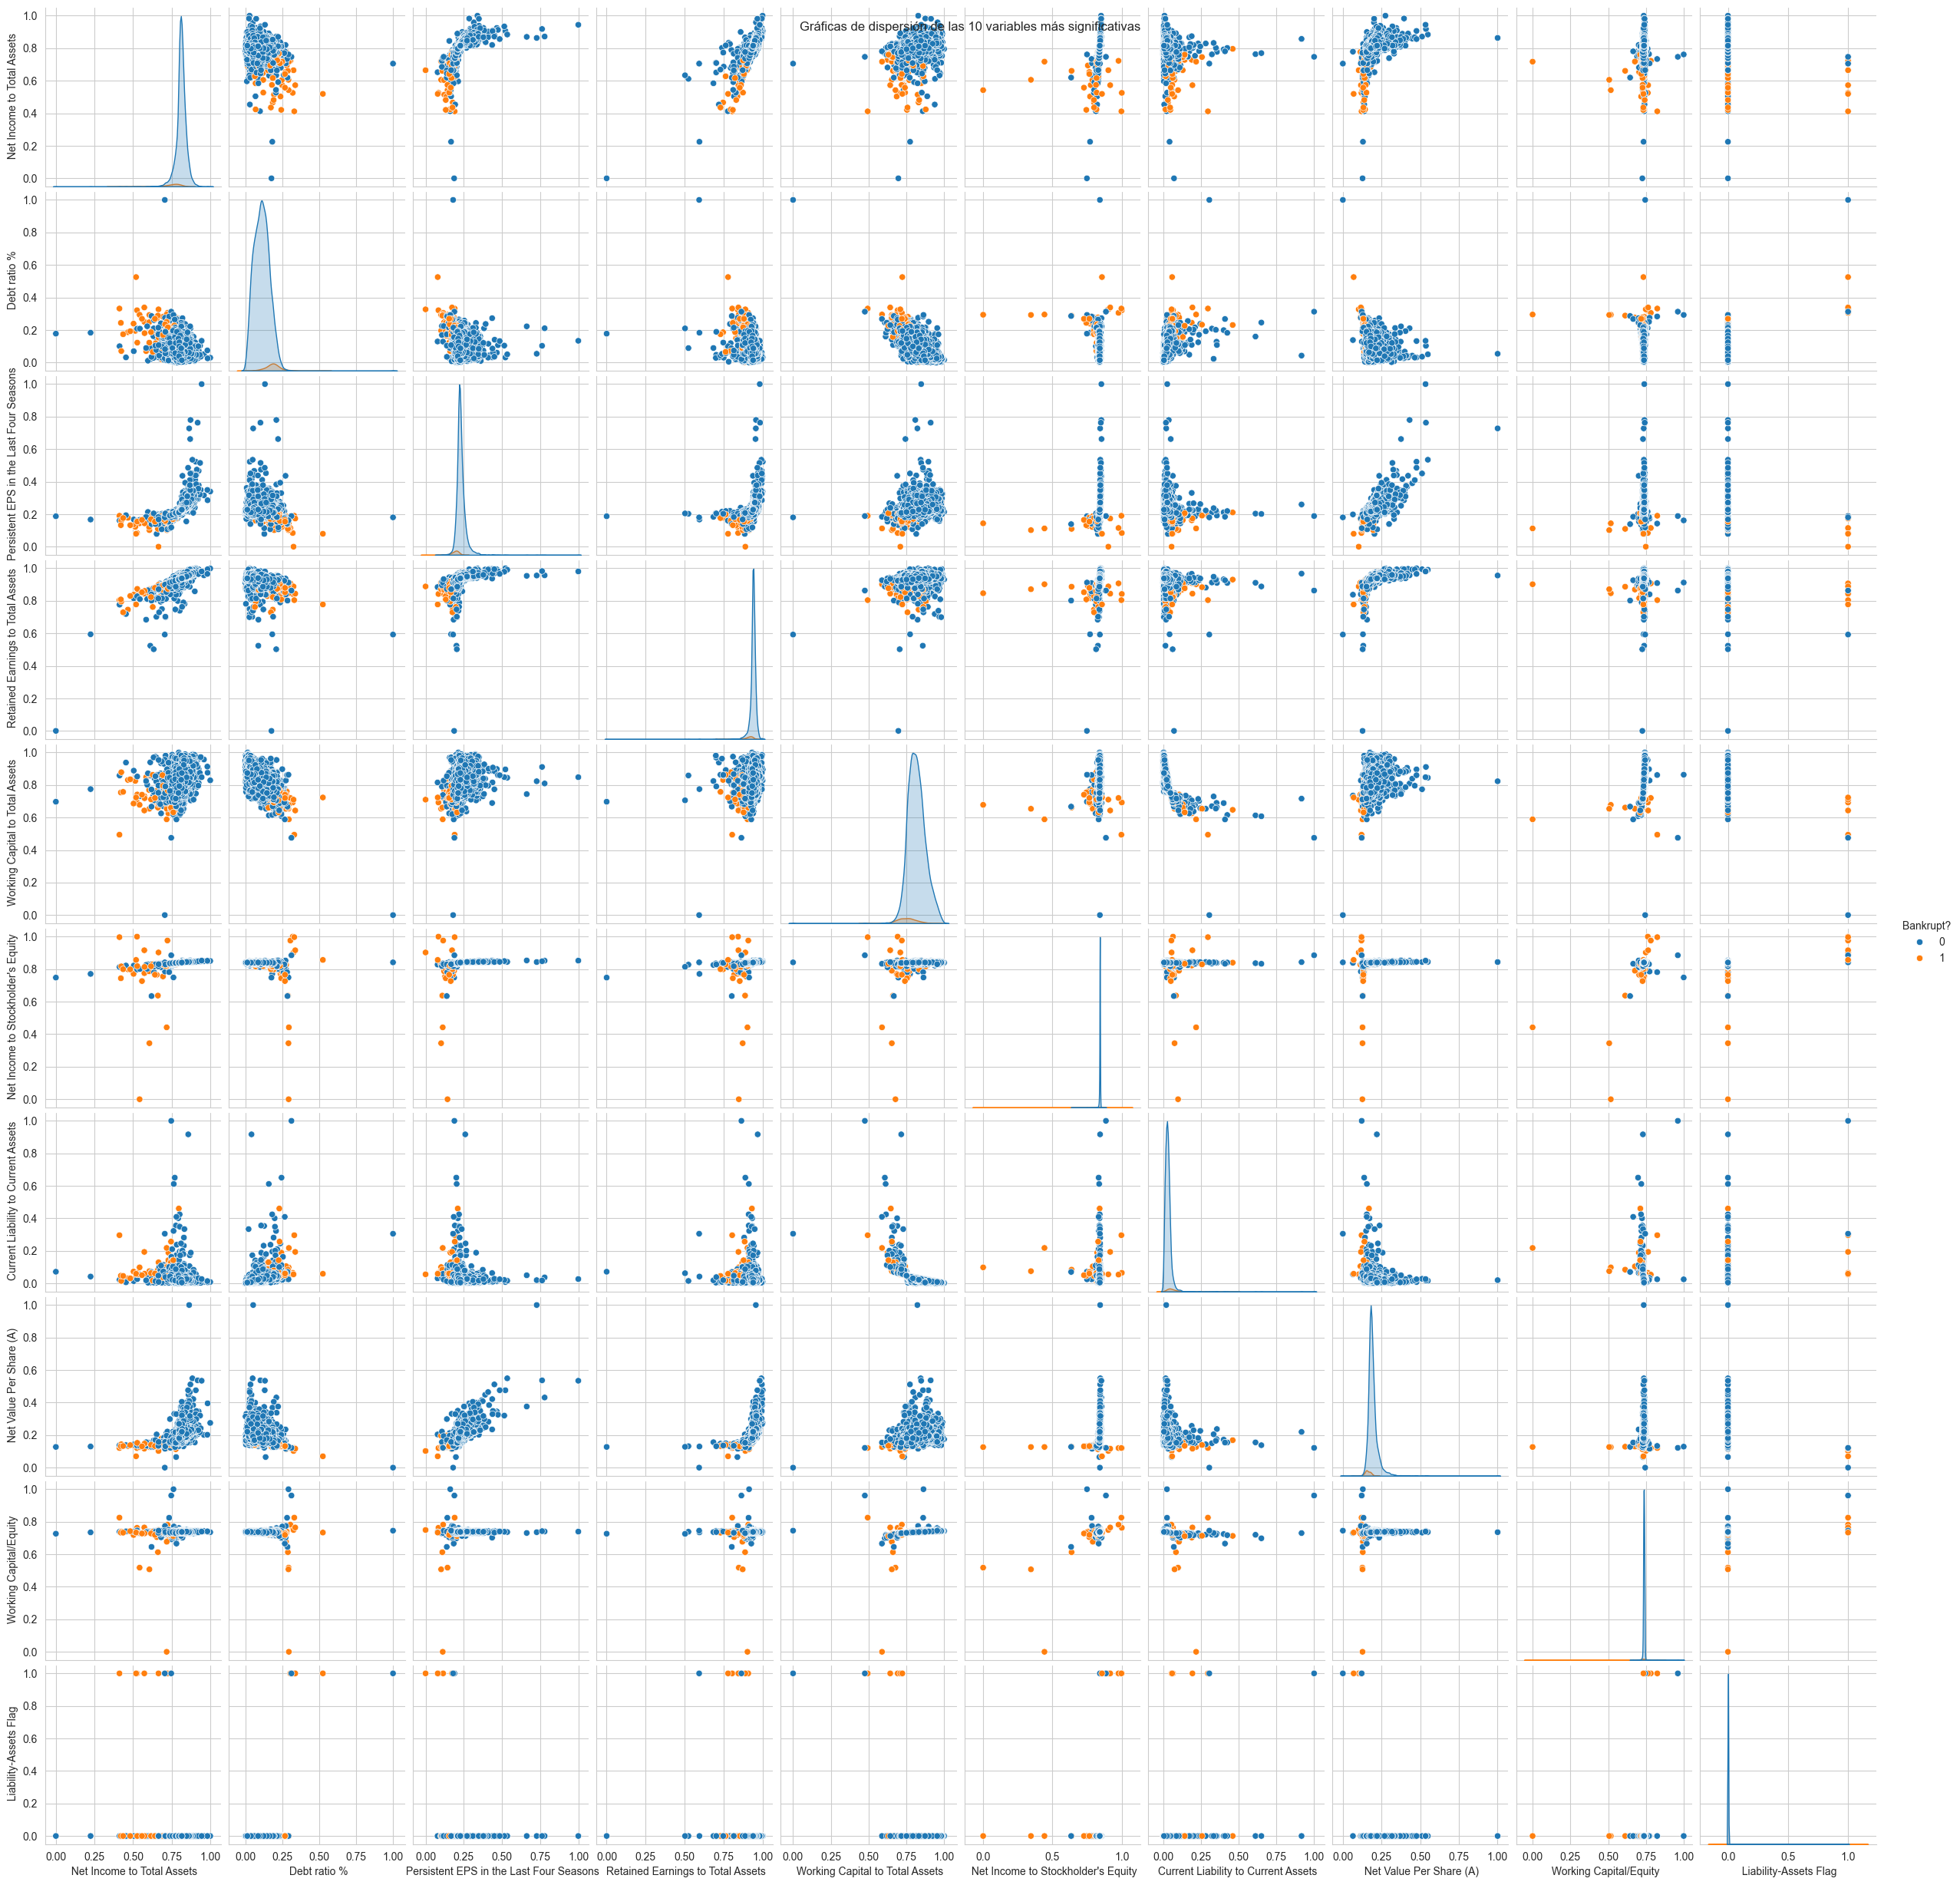

In [57]:
# Gráficas de dispersión para las 10 variables más significativas sin normalizar
sns.pairplot(data[top_variables + ['Bankrupt?']], hue='Bankrupt?')
plt.suptitle('Gráficas de dispersión de las 10 variables más significativas')
plt.show()

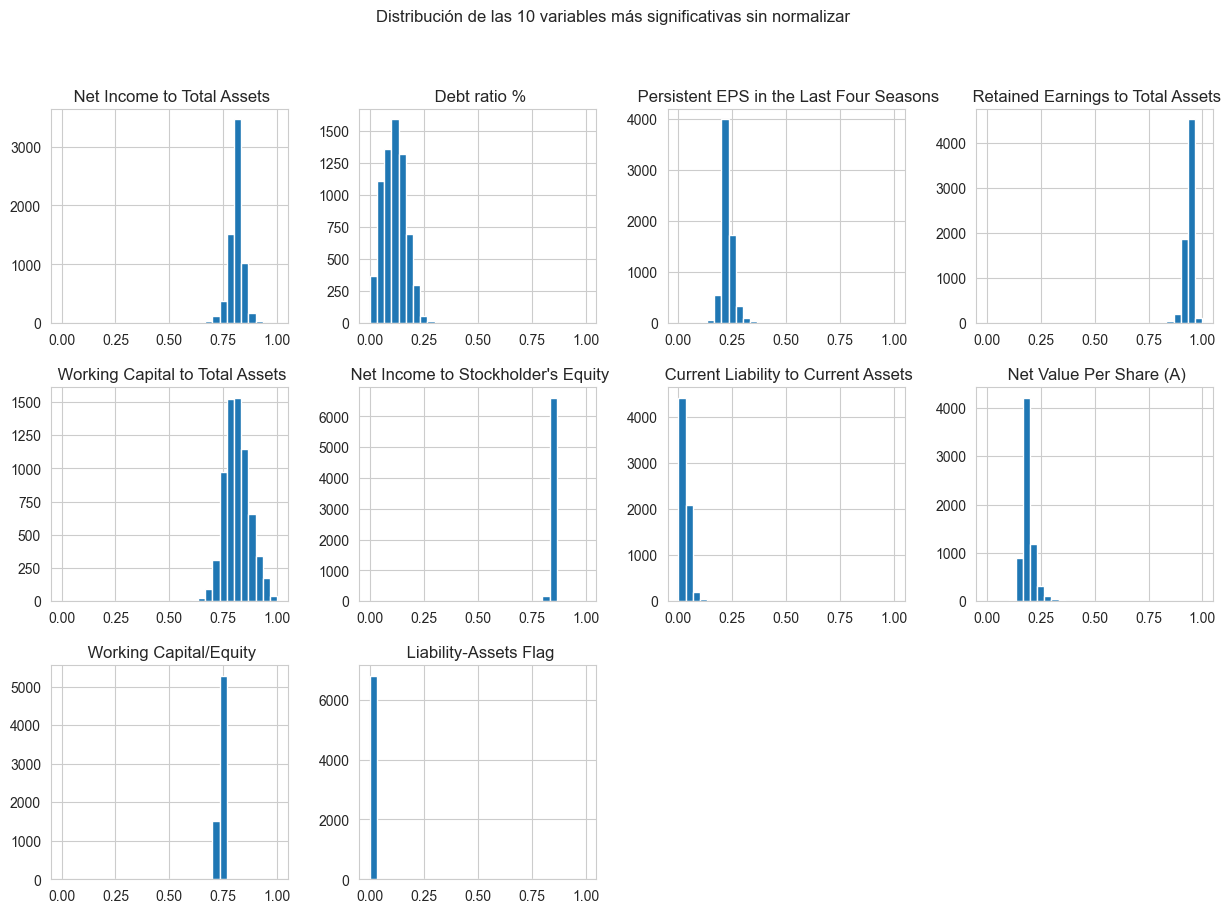

In [58]:
# Histograma de las 10 variables más significativas sin normalizar
data[top_variables].hist(bins=30, figsize=(15, 10), layout=(3, 4))
plt.suptitle('Distribución de las 10 variables más significativas sin normalizar')
plt.show()


### Transformaciones de datos

Si encontramos variables con distribuciones sesgadas, podemos aplicar transformaciones para normalizarlas.

In [ ]:
from scipy.stats import boxcox

# Aplicar transformación Box-Cox a una variable sesgada
data['X1_transformed'], _ = boxcox(data['X1'] + 1)  # Añadir 1 para evitar valores cero

# Verificar la transformación
plt.figure(figsize=(10, 6))
sns.histplot(data['X1_transformed'], bins=30, kde=True)
plt.title('Distribución de X1 después de la transformación Box-Cox')
plt.show()


Este proceso de exploración nos ayudará a entender mejor los datos y a preparar el dataset para el modelado.